## 概要
- VAEを使った異常検知をMNISTでテストしてみる
- MNISTの0ラベルの画像だけを学習させてデコーダーの結果を見てみる

## モジュールのインポート

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from scipy.stats import norm

Using TensorFlow backend.


## データの前処理

In [2]:
# ネットワークパラメータの設定
batch_size = 90
n_epochs = 100
n_hidden = 256
z_dim = 2

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [10]:
X_train = X_train[np.where(y_train == 0)[0]]
y_train = [0 for _ in range(len(np.where(y_train == 0)[0]))]
X_test = X_test[np.where(y_test == 0)[0]]
y_test = [0 for _ in range(len(np.where(y_test == 0)[0]))]

In [11]:
# 前処理
X_train = X_train[:X_train.shape[0] // batch_size * batch_size].astype("float32") / 255
X_test = X_test[:X_test.shape[0] // batch_size * batch_size].astype("float32") / 255

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print(X_train.shape, X_test.shape)

(5850, 784) (900, 784)


## モデルの構築

In [12]:
# エンコーダ
x = Input(shape=(X_train.shape[1:]))
x_encoded = Dense(n_hidden, activation="relu")(x)
x_encoded = Dense(n_hidden//2, activation="relu")(x_encoded)

mu = Dense(z_dim)(x_encoded)
log_var = Dense(z_dim)(x_encoded)

In [13]:
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])

In [14]:
# デコーダ
z_decoder1 = Dense(n_hidden//2, activation="relu")
z_decoder2 = Dense(n_hidden, activation="relu")
y_decoder = Dense(X_train.shape[1], activation="sigmoid")

z_decoded = z_decoder1(z)
z_decoded = z_decoder2(z_decoded)
y = y_decoder(z_decoded)

- kl_loss
    - カルバック・ライブラー情報量
    - 確率論と情報理論を組み合わせた２つの確率分布がどの程度似ているかを表す尺度

$$ loss = \frac{1}{2} \sum^{N_z}_{j=1} (\mu^{2}_{z_j} + \sigma^{2}_{z_j} - \log{\sigma^2_{z_j} - 1}) \\ = \frac{1}{2} \cdot \sum^{N_z}_{j=1} (\mu^{2}_{z_j} + \exp(\log{\sigma}) - \log{\sigma} - 1)?$$


In [15]:
# loss
reconstruction_loss = objectives.binary_crossentropy(x, y) * X_train.shape[1]
kl_loss = kl_loss = - 0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)
vae_loss = reconstruction_loss + kl_loss

In [16]:
# build model
vae = Model(x, y)
vae.add_loss(vae_loss)
vae.compile(optimizer="rmsprop")
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          32896       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            258         dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

In [17]:
vae.fit(X_train,
        shuffle=True,
        epochs=n_epochs,
        batch_size=batch_size,
        validation_data=(X_test, None),
        verbose=1)

Train on 5850 samples, validate on 900 samples
Epoch 1/100
5850/5850 [==============================] - 4s 721us/step - loss: 241.9391 - val_loss: 186.0637
Epoch 2/100
5850/5850 [==============================] - 2s 334us/step - loss: 179.4235 - val_loss: 173.8799
Epoch 3/100
5850/5850 [==============================] - 2s 346us/step - loss: 172.1033 - val_loss: 173.7408
Epoch 4/100
5850/5850 [==============================] - 2s 373us/step - loss: 169.9924 - val_loss: 170.2284
Epoch 5/100
5850/5850 [==============================] - 2s 320us/step - loss: 168.3248 - val_loss: 168.1248 loss: 16
Epoch 6/100
5850/5850 [==============================] - 2s 336us/step - loss: 163.6566 - val_loss: 159.8877
Epoch 7/100
5850/5850 [==============================] - 2s 344us/step - loss: 158.4671 - val_loss: 154.7658
Epoch 8/100
5850/5850 [==============================] - 2s 342us/step - loss: 155.4984 - val_loss: 151.4102
Epoch 9/100
5850/5850 [==============================] - 2s 342us/step -

In [18]:
# build encoder
encoder = Model(x, mu)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 234,114
Trainable params: 234,114
Non-trainable params: 0
_________________________________________________________________


In [19]:
# build decoder
decoder_input = Input(shape=(z_dim,))
_z_decoded = z_decoder1(decoder_input)
_z_decoded = z_decoder2(_z_decoded)
_y = y_decoder(_z_decoded)
generator = Model(decoder_input, _y)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 784)               201488    
Total params: 234,896
Trainable params: 234,896
Non-trainable params: 0
_________________________________________________________________


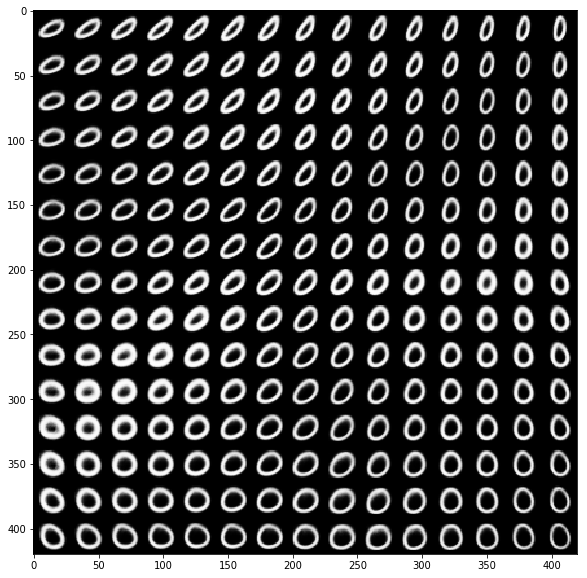

In [22]:
# display a 2D manifold of the digits
# 0 に対して分布を見てみる
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

## まとめ
VAEによる1種類の生成モデルを学習させることで1枚の画像の分布を得ることができるのでこれを用いて画像比較ができる。